In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

print('Data source import complete.')
print(fanconic_skin_cancer_malignant_vs_benign_path)


Data source import complete.
/kaggle/input/skin-cancer-malignant-vs-benign


# 1. RUN THE CODE IN GOOGLE COLAB !

Image segmentation

Even though the glob API is very simple, the module packs a lot of power. It is useful in any situation where your program needs to look for a list of files on the filesystem with names matching a pattern. If you need a list of filenames that all have a certain extension, prefix, or any common string in the middle, use glob instead of writing code to scan the directory contents yourself.

The pattern rules for glob are not regular expressions. Instead, they follow standard Unix path expansion rules. There are only a few special characters: two different wild-cards, and character ranges are supported. The patterns rules are applied to segments of the filename (stopping at the path separator, /). Paths in the pattern can be relative or absolute. Shell variable names and tilde (~) are not expanded.

Example Data¶

Image segmentation is the process of partitioning an image into multiple different regions (or segments). The goal is to change the representation of the image into an easier and more meaningful image.

It is an important step in image processing, as real world images doesn't always contain only one object that we wanna classify. For instance, for self driving cars, the image would contain the road, cars, pedestrians, etc. So we may need to use segmentation here to separate objects and analyze each object individually (i.e image classification) to check what it is.

K-Means clustering is unsupervised machine learning algorithm that aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest mean. A cluster refers to a collection of data points aggregated together because of certain similarities. For image segmentation, clusters here are different image colors.


Image segmentation is an essential topic in an image processing framework. It is the process to classify an image into different groups. There are many different methods, and k-means is one of the most popular methods.

In [ ]:
from glob import glob

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans

#https://medium.com/spinor/a-straightforward-introduction-to-image-thresholding-using-python-f1c085f02d5e
#https://datacarpentry.org/image-processing/07-thresholding/
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
#https://campus.datacamp.com/courses/introduction-to-data-visualization-in-python/analyzing-time-series-and-images?ex=13
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi

In [ ]:
import os

# Check if the dataset is present and its structure
dataset_path = '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/'
print("Contents of the dataset path:", os.listdir(dataset_path))

# List all files in the 'malignant' and 'benign' folders
mal_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/*')
ben_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign/*')

print("Malignant images:", mal_images)
print("Benign images:", ben_images)


Contents of the dataset path: ['benign', 'malignant']
Malignant images: ['/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1269.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/623.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/764.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1075.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/820.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/473.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1411.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1031.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1385.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/333.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/1024.jpg', '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malig

In [ ]:
len(mal_images)
print(len(ben_images))

1440

In [ ]:
def binary(image):
    return image > threshold_otsu(image)

def equalize(image):
    return hist.equalize_hist(image)

#https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
def mean_filter(image, raio_disk):
    return rank.mean_percentile(image, selem = disk(raio_disk))

def preenche_bords(image):
    return ndi.binary_fill_holes(image)

#https://www.unioviedo.es/compnum/labs/PYTHON/intro_image.html

def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp

def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);


def plot_camadas(img):
    plt.figure(figsize = (15, 25))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:,:,i], cmap = 'gray');

def d2Kmeans(img, k):
    return KMeans(n_jobs=-1,
                  random_state=1,
                  n_clusters = k,
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def elbow(img, k):
    hist = []
    for kclusters in  range(1, k):
        Km = KMeans(n_jobs=-1, random_state=1, n_clusters = kclusters, init='k-means++').fit(img.reshape((-1,1)))
        hist.append(Km.inertia_)

    plt.figure(figsize = (15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Soma das distâncias quadradas')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show();



In [ ]:
mal = load_images(mal_images)
ben = load_images(ben_images)

In [ ]:
print("First 5 malignant image paths:", mal[:5])
print("First 5 benign image paths:", ben[:5])


First 5 malignant image paths: [array([[[173, 126, 144],
        [191, 132, 150],
        [186, 133, 151],
        ...,
        [197, 159, 172],
        [199, 161, 174],
        [200, 159, 173]],

       [[196, 135, 150],
        [208, 141, 158],
        [201, 141, 153],
        ...,
        [223, 176, 184],
        [227, 175, 187],
        [221, 171, 182]],

       [[190, 129, 147],
        [203, 134, 153],
        [199, 135, 151],
        ...,
        [216, 168, 182],
        [216, 168, 184],
        [218, 170, 186]],

       ...,

       [[198, 152, 163],
        [214, 160, 173],
        [216, 162, 175],
        ...,
        [218, 180, 193],
        [219, 178, 192],
        [215, 177, 190]],

       [[202, 151, 166],
        [213, 162, 171],
        [213, 159, 172],
        ...,
        [218, 179, 197],
        [219, 177, 187],
        [219, 176, 193]],

       [[203, 152, 169],
        [215, 163, 175],
        [211, 157, 170],
        ...,
        [218, 181, 198],
        [215, 182

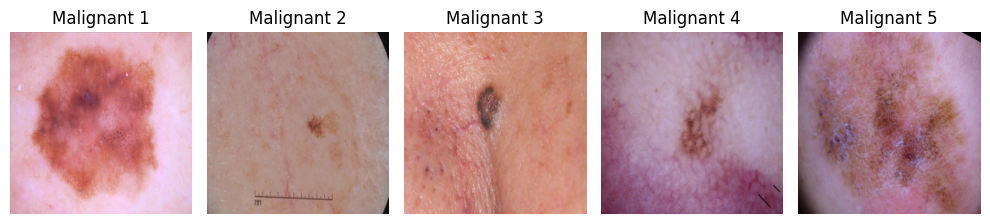

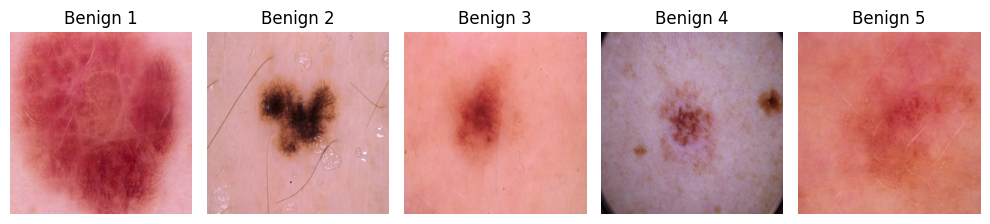

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread

def plot_images(image_paths, title):
    """Function to display a set of images in a grid."""
    # Set up the grid for displaying images
    plt.figure(figsize=(10, 10))

    # Loop through the image paths and display them
    for i, img_path in enumerate(image_paths[:5]):  # Limiting to first 5 images for now
        if isinstance(img_path, str):  # Check if it's a path
            img = imread(img_path)
        else:
            img = img_path  # If it's already an image array, use it directly

        plt.subplot(1, 5, i + 1)  # Create a subplot (1 row, 5 columns)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.title(f'{title} {i+1}')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Assuming mal and ben are lists of file paths or image arrays for malignant and benign images
plot_images(mal, 'Malignant')
plot_images(ben, 'Benign')


In [ ]:
img_selected = mal[1]

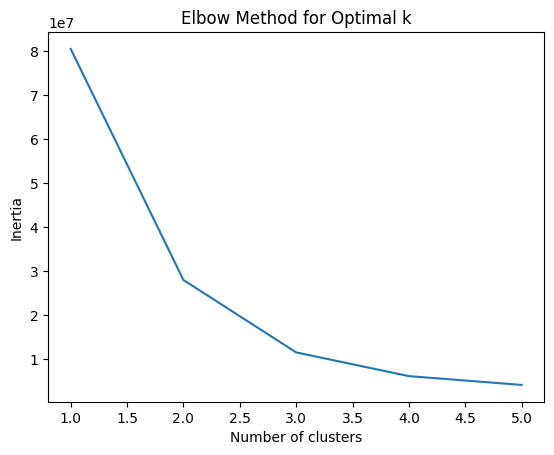

In [ ]:
from sklearn.cluster import KMeans

def elbow(img, k):
    hist = []
    for kclusters in range(1, k):
        Km = KMeans(random_state=1, n_clusters=kclusters, init='k-means++').fit(img.reshape((-1, 1)))
        hist.append(Km.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, k), hist)
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Call the elbow function with img_selected and desired k value (e.g., 6)
elbow(img_selected, 6)


In [ ]:
k_klusters = 2

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from skimage.color import rgb2gray

def d2Kmeans(img, k):
    # If the image is grayscale, no need to reshape
    if len(img.shape) == 2:  # Grayscale image
        img_reshaped = img.reshape((-1, 1))  # Flatten to (height*width, 1)
    else:  # Color image (RGB)
        img_reshaped = img.reshape((-1, 3))  # Flatten to (height*width, 3)

    # Apply KMeans to the reshaped image
    kmeans = KMeans(n_init=10, random_state=1, n_clusters=k)
    return kmeans.fit_predict(img_reshaped)

# For grayscale image (no need to reshape beyond this)
result_gray = d2Kmeans(rgb2gray(img_selected), k_klusters)

# For color image (flatten it first)
result_img = d2Kmeans(img_selected, k_klusters)


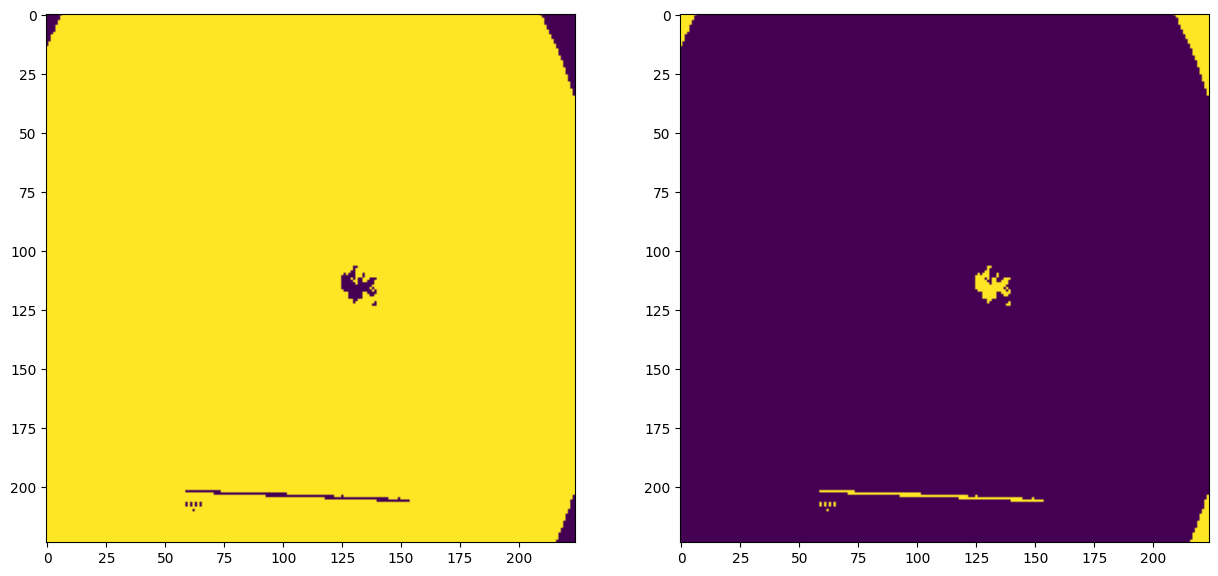

In [ ]:
# Get original image shape (after grayscale conversion)
h, w = rgb2gray(img_selected).shape

# Create and reshape clusters back to 2D
klusters_gray = [(result_gray == i).reshape(h, w) for i in range(k_klusters)]

# Now plot
plot_any(klusters_gray)


In [ ]:
def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index

In [ ]:
index_kluster = select_cluster_index(klusters_gray)
print(index_kluster)
selecionado = klusters_gray[index_kluster]

1


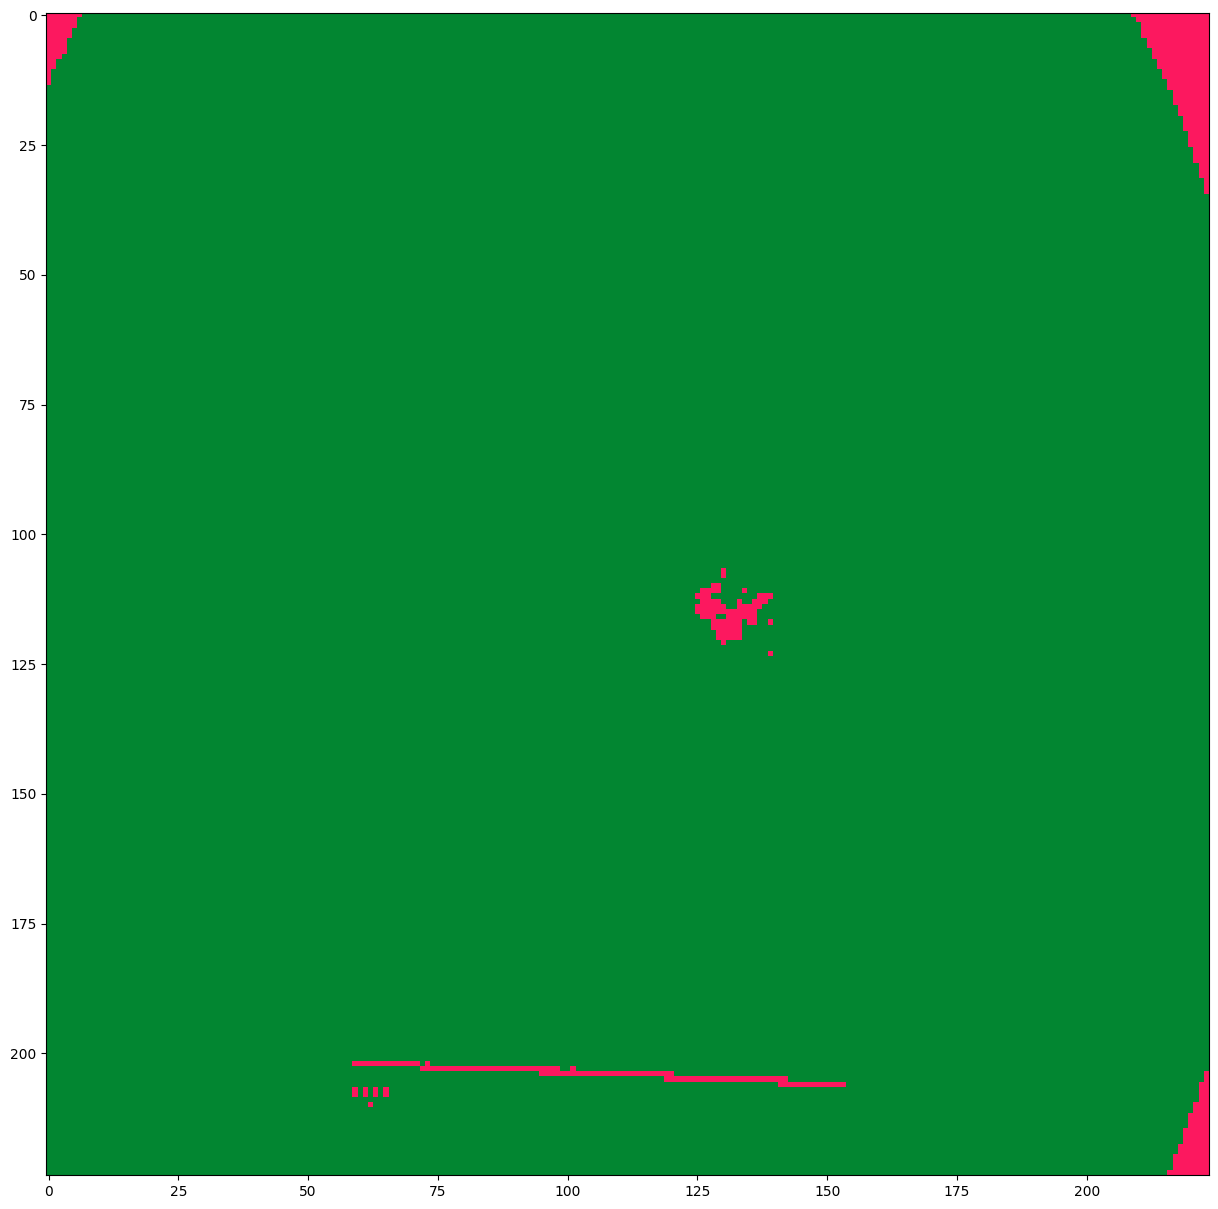

In [ ]:
import numpy as np

# Get original height and width
h, w, _ = img_selected.shape

# Reshape result_img to 2D
result_img_2d = result_img.reshape(h, w)

# Create an empty color image
segmented_img = np.zeros((h, w, 3), dtype=np.uint8)

# Assign a random color to each cluster
colors = np.random.randint(0, 255, size=(k_klusters, 3))

# Color each pixel according to its cluster
for K in range(k_klusters):
    segmented_img[result_img_2d == K] = colors[K]

# Now plot
plot_any([segmented_img])


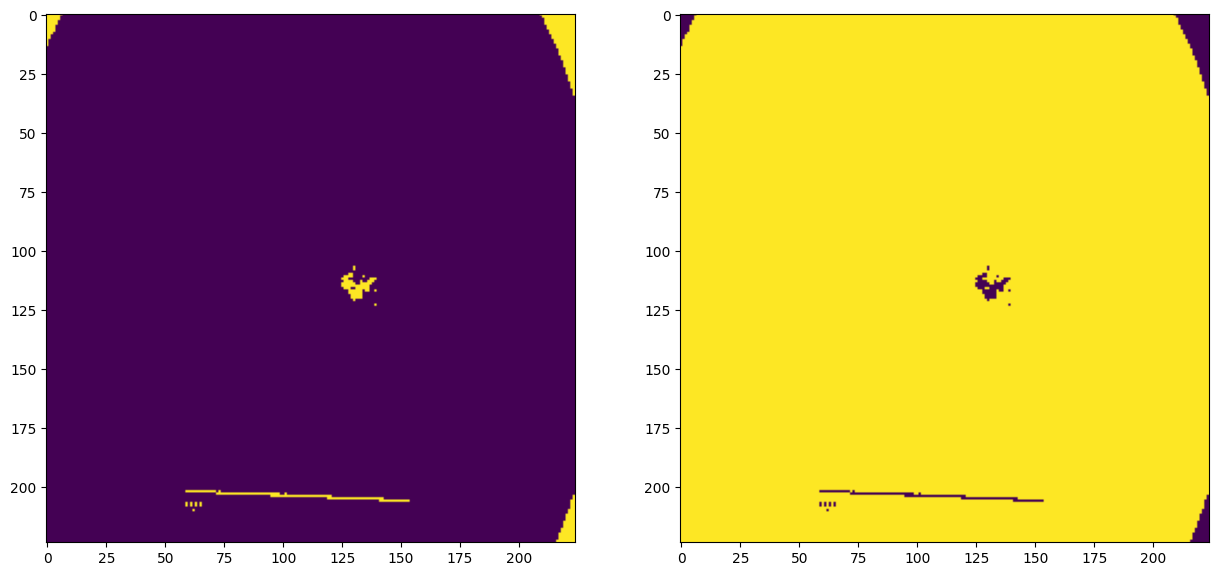

In [ ]:
# Reshape result_img back to 2D
h, w, _ = img_selected.shape
result_img_2d = result_img.reshape(h, w)

# Create cluster masks
clusters = [(result_img_2d == K) for K in range(k_klusters)]

# Plot
plot_any(clusters)


In [ ]:
clusters

[array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])]

In [ ]:
new_img = merge_segmented_mask_ROI(img_selected, selecionado)

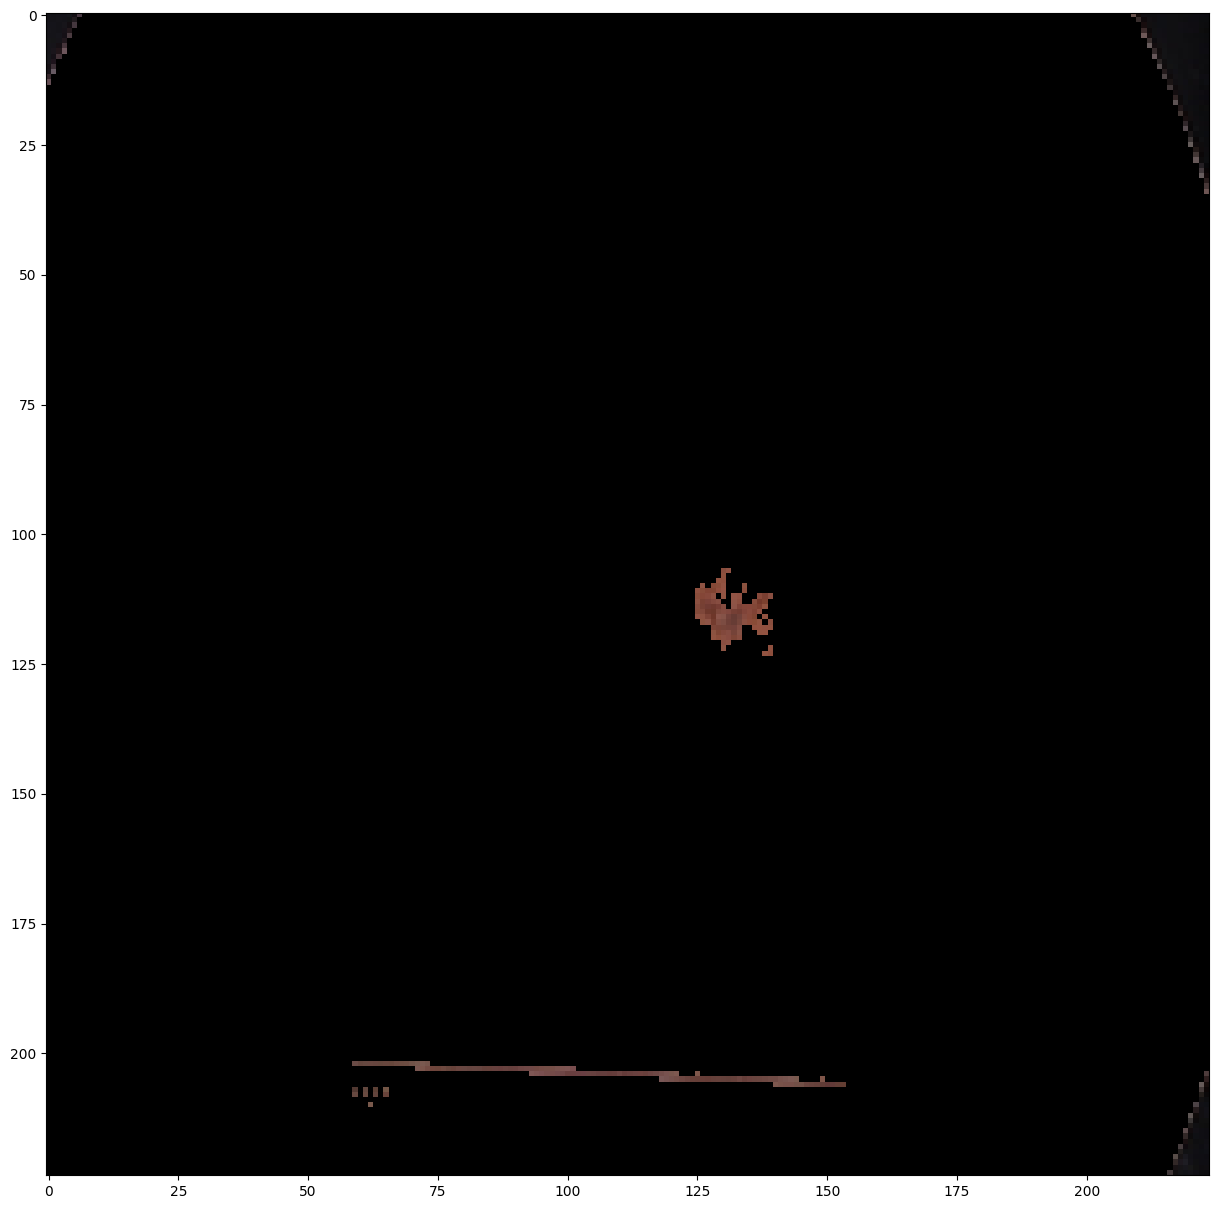

In [ ]:
plot_any([new_img])

In [ ]:
import numpy as np

# Make sure the image is uint8 (0–255) before applying mean_filter
selecionado = (selecionado.astype(np.uint8)) * 255

# Apply mean filter
image_mean_filter = mean_filter(selecionado, 20)

# Apply binary operation
test_binary = binary(image_mean_filter)


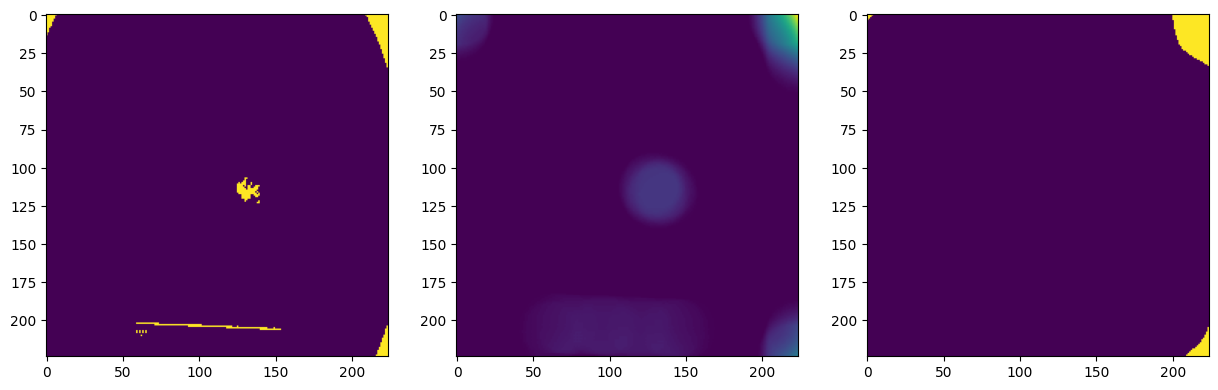

In [ ]:
plot_any([selecionado, image_mean_filter, test_binary])

In [ ]:
final_result = merge_segmented_mask_ROI(img_selected ,test_binary)

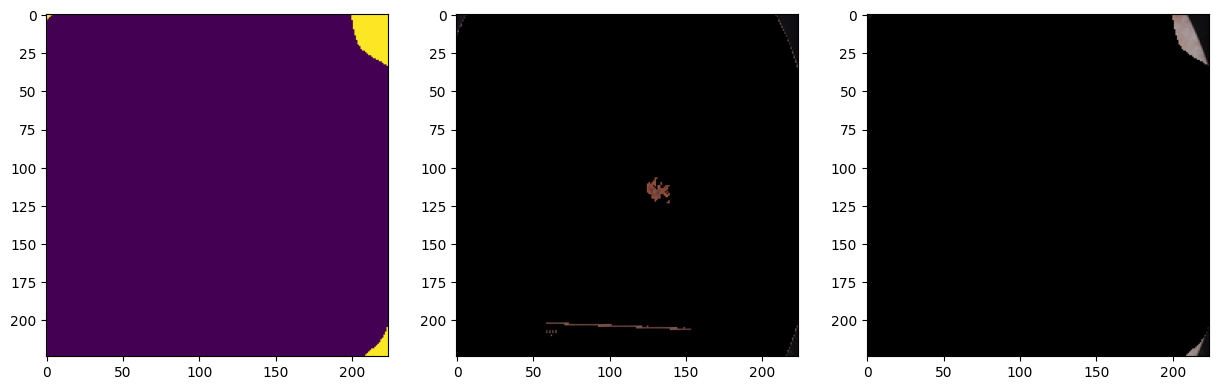

In [ ]:
plot_any([test_binary, new_img, final_result])

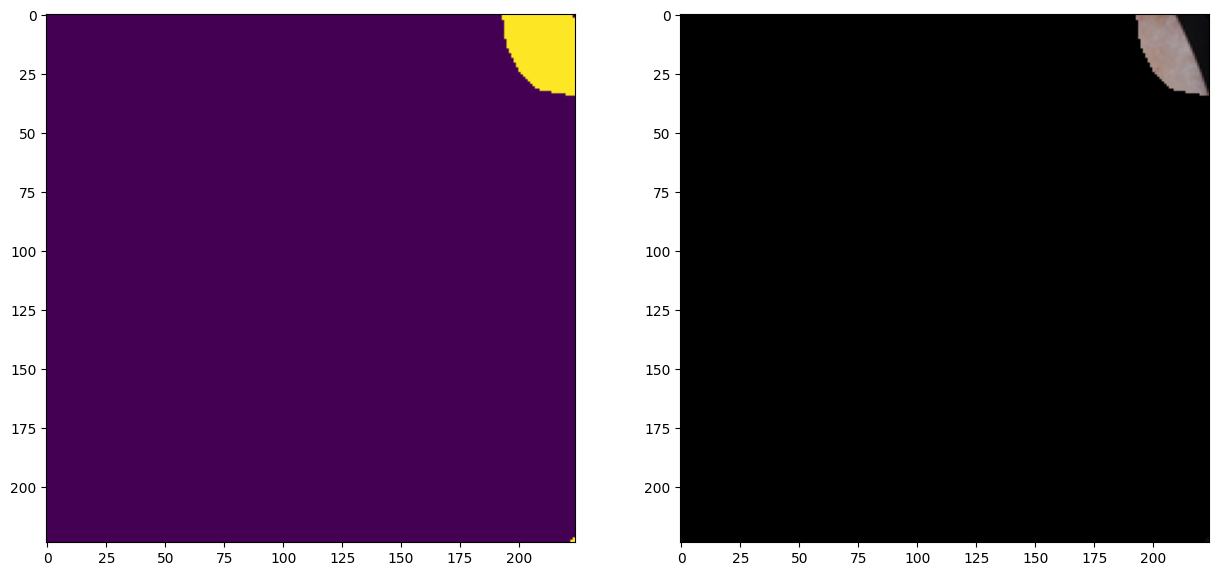

In [ ]:
max_mean = 0
img_gray = rgb2gray(final_result)
img_bin = binary(img_gray)
x, y = img_bin.shape

limits_before = []
for i in range(x):
    for j in range(y):
        if img_bin[i, j]:
            limits_before.append(j)

stop_before = (sum(limits_before) // len(limits_before)) // 2
img_copy = img_bin.copy()

for i in range(x):
    for j in range(stop_before):
        img_copy[i, j] = 0

limits_after = []
for i in range(x):
    for j in range(y - 1, 0, -1):
        if img_copy[i, j]:
            limits_after.append(j)

stop_after = sum(limits_after) // len(limits_after) + min(limits_after)

for i in range(x):
    for j in range(stop_after, y):
        img_copy[i, j] = 0

# IMPORTANT: convert before mean_filter
img_copy = (img_copy.astype(np.uint8)) * 255

mean_result = mean_filter(img_copy, 15)
mean_result = binary(mean_result)
final_result = merge_segmented_mask_ROI(img_selected, mean_result)

plot_any([mean_result, final_result])


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
img = cv2.imread(mal_images[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()
#plotting
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

array([[[ 24,  19,  20],
        [ 23,  18,  19],
        [ 25,  19,  20],
        ...,
        [ 18,  13,  14],
        [ 17,  12,  13],
        [ 16,  11,  12]],

       [[ 24,  19,  20],
        [ 24,  19,  20],
        [ 25,  20,  21],
        ...,
        [ 18,  13,  14],
        [ 15,  13,  12],
        [ 15,  13,  12]],

       [[ 26,  20,  21],
        [ 26,  20,  21],
        [ 24,  19,  20],
        ...,
        [ 18,  13,  15],
        [ 15,  13,  13],
        [ 14,  12,  12]],

       ...,

       [[115, 112, 137],
        [115, 115, 139],
        [115, 117, 141],
        ...,
        [ 18,  16,  16],
        [ 19,  14,  15],
        [ 19,  14,  15]],

       [[111, 110, 130],
        [115, 114, 134],
        [116, 119, 140],
        ...,
        [ 17,  17,  17],
        [ 16,  13,  15],
        [ 17,  14,  16]],

       [[ 96,  97, 118],
        [114, 115, 136],
        [115, 117, 141],
        ...,
        [ 21,  15,  16],
        [ 15,  13,  13],
        [ 14,  12,  12]]], dtype=uint8)
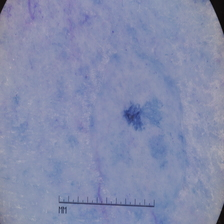

In [ ]:
original_image = cv2.imread(mal_images[1])
original_image


In [ ]:
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

In [ ]:
vectorized = img.reshape((-1,3))

In [ ]:
vectorized = np.float32(vectorized)

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [ ]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [ ]:
center = np.uint8(center)

In [ ]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

In [ ]:
print(res.shape, res.dtype, np.min(res), np.max(res))


(50176, 3) uint8 36 174


img shape: (224, 224, 3)
res shape: (50176, 3)
res dtype: uint8
res min-max: 36 174


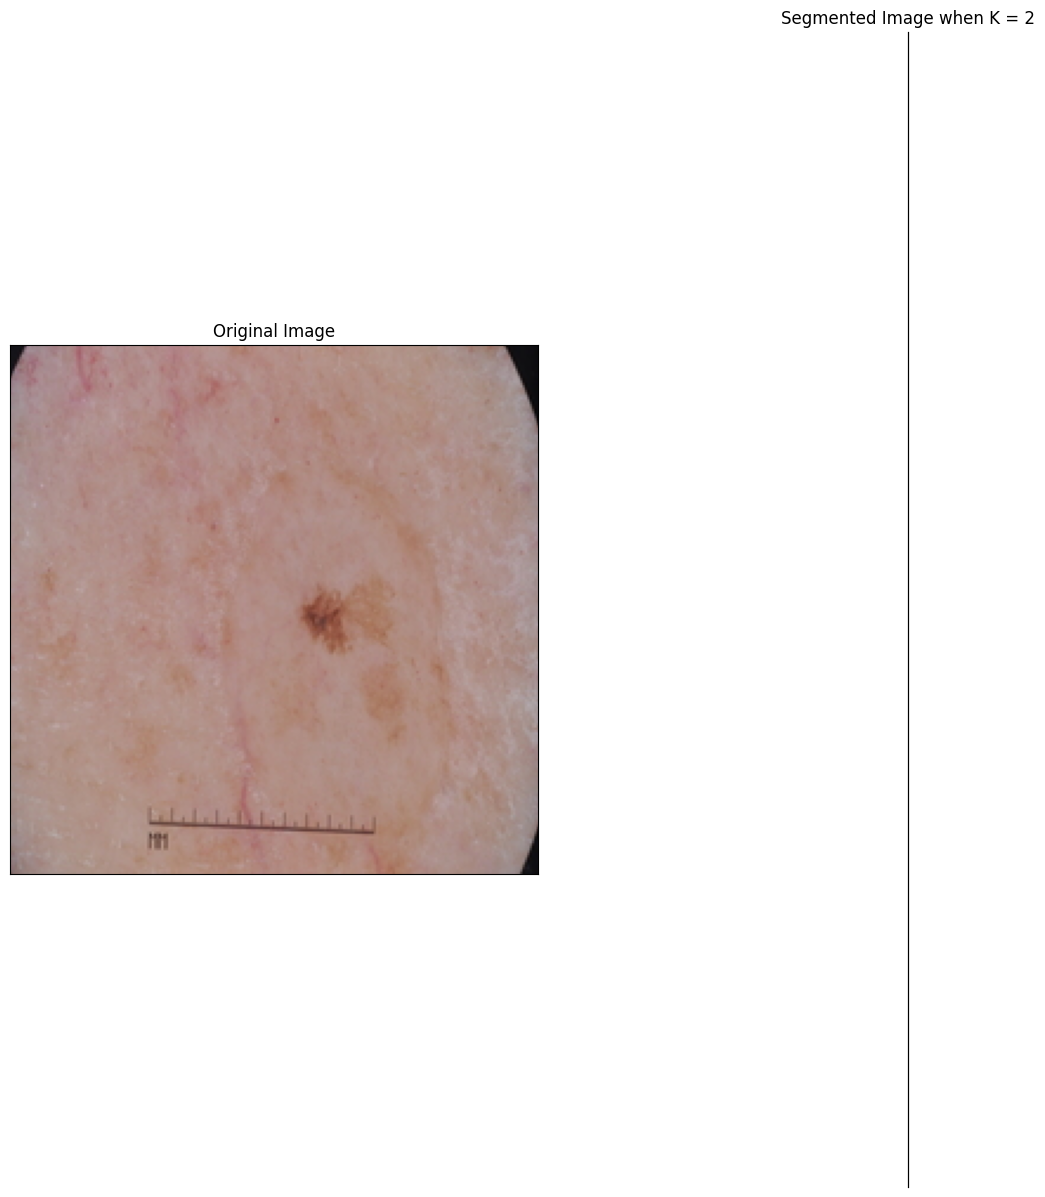

In [ ]:
# Make sure matplotlib inline works in Colab
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Check if images are valid
print("img shape:", img.shape)
print("res shape:", res.shape)

# Check the dtype and range of values for res
print("res dtype:", res.dtype)
print("res min-max:", np.min(res), np.max(res))

figure_size = 15
plt.figure(figsize=(figure_size, figure_size))

# Plot Original Image
plt.subplot(1, 2, 1)
if img.ndim == 2:  # Grayscale
    plt.imshow(img, cmap='gray')
else:  # Color Image
    plt.imshow(img)
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

# Plot Segmented Image
plt.subplot(1, 2, 2)
if res.ndim == 2:  # Grayscale
    plt.imshow(res, cmap='gray')
else:  # Color Image
    plt.imshow(res)
plt.title('Segmented Image when K = %i' % K)
plt.xticks([]), plt.yticks([])

# Display the plot
plt.show()  # This should work perfectly in Colab


1. K Means Clustering for Imagery Analysis

we will use a K-means algorithm to perform image classification. Clustering isn’t limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

In [ ]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


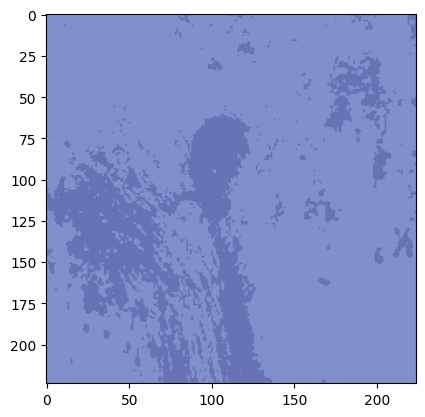

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

image = cv2.imread(mal_images[2])
(h1, w1) = image.shape[:2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 2)

labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

#reshape the feature vectors to images
quant = quant.reshape((h1, w1, 3))
image = image.reshape((h1, w1, 3))

# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)



plt.imshow(quant)




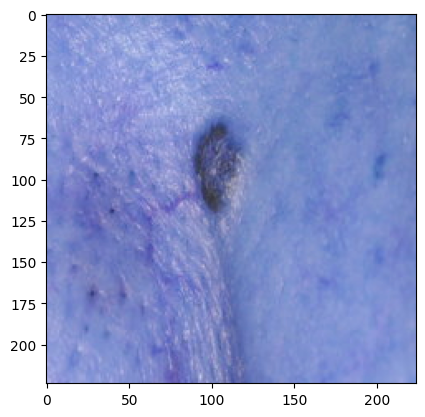

In [ ]:
plt.imshow(image)

ML

Structure of an Image Classification Task
Image Preprocessing - The aim of this process is to improve the image data(features) by suppressing unwanted distortions and enhancement of some important image features so that our Computer Vision models can benefit from this improved data to work on.
Detection of an object - Detection refers to the localization of an object which means the segmentation of the image and identifying the position of the object of interest.
Feature extraction and Training- This is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes. This process where the model learns the features from the dataset is called model training.
Classification of the object - This step categorizes detected objects into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns.

In [ ]:
mal_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/*')
ben_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign/*')


In [ ]:
len(mal_images)

1197

In [ ]:
#Reading Image
import pandas as pd
train_data =[]
for img in  mal_images :
    train_data.append((img,0))

for img in ben_images :
    train_data.append((img,1))


train_data = pd.DataFrame(train_data, columns = ['image','label'] , index = None)
train_data['image'][0]
train_data

,image,label
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,0
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,0
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,0
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,0
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,0
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,1
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,1
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,1


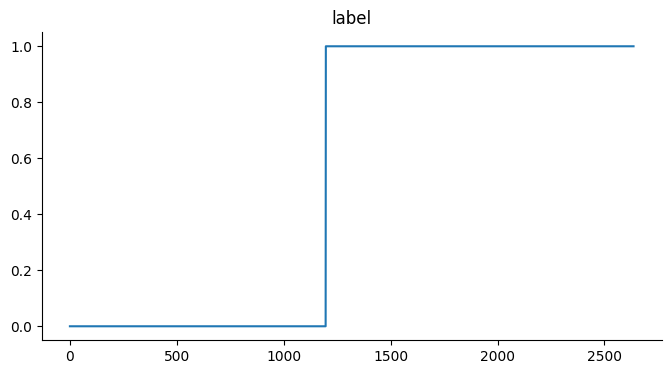

In [ ]:
# @title label

from matplotlib import pyplot as plt
train_data['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
mal_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/*')


In [ ]:
import cv2

W = 256  # Width of the resized image
path = '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/'

# Loop through the files and process the images
for filename in os.listdir(path):
    if filename.endswith('.jpg'):  # Process only .jpg images
        print(f"Processing {filename}")

        # Load the image
        oriimg = cv2.imread(path + filename)
        if oriimg is not None:
            height, width, depth = oriimg.shape
            imgScale = W / width
            newX, newY = oriimg.shape[1] * imgScale, oriimg.shape[0] * imgScale
            newimg = cv2.resize(oriimg, (int(newX), int(newY)))

            # Convert to grayscale
            newimg = cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)

            # Save the processed image
            cv2.imwrite(path + filename.split('.')[0] + "-resized.jpg", newimg)
            print(f"Image {filename} saved successfully.")
        else:
            print(f"Failed to load {filename}")


Processing 1269.jpg
Image 1269.jpg saved successfully.
Processing 623.jpg
Image 623.jpg saved successfully.
Processing 764.jpg
Image 764.jpg saved successfully.
Processing 1075.jpg
Image 1075.jpg saved successfully.
Processing 820.jpg
Image 820.jpg saved successfully.
Processing 473.jpg
Image 473.jpg saved successfully.
Processing 1411.jpg
Image 1411.jpg saved successfully.
Processing 1031.jpg
Image 1031.jpg saved successfully.
Processing 1385.jpg
Image 1385.jpg saved successfully.
Processing 333.jpg
Image 333.jpg saved successfully.
Processing 1024.jpg
Image 1024.jpg saved successfully.
Processing 537.jpg
Image 537.jpg saved successfully.
Processing 45.jpg
Image 45.jpg saved successfully.
Processing 369.jpg
Image 369.jpg saved successfully.
Processing 56.jpg
Image 56.jpg saved successfully.
Processing 654.jpg
Image 654.jpg saved successfully.
Processing 89.jpg
Image 89.jpg saved successfully.
Processing 20.jpg
Image 20.jpg saved successfully.
Processing 1161.jpg
Image 1161.jpg saved s

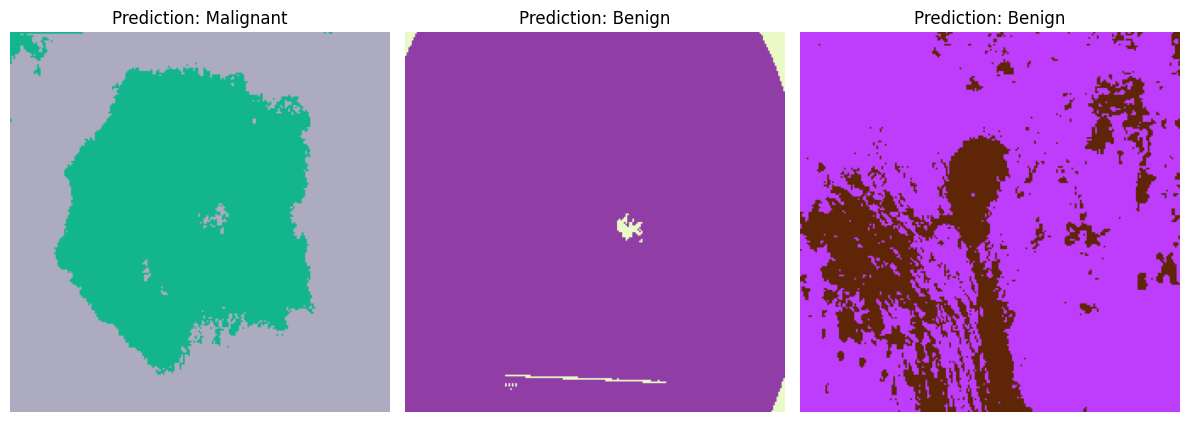

In [ ]:
# prompt: give the result of an image to show if the cancer is malignant or benign, and give the name,
# use the image_path as the path of an random image from the above dataset, add multiple images not one(plot all those taken)
# and finally try to name the cancer type

import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

# Function to perform image segmentation and prediction
def predict_cancer_type(image_paths):
    results = []
    for image_path in image_paths:
        try:
            # Load the image
            img = imread(image_path)

            # Convert to grayscale
            gray = rgb2gray(img)

            # Apply KMeans clustering
            k_klusters = 2  # Adjust as needed
            result_img = KMeans(n_init=10, random_state=1, n_clusters=k_klusters).fit_predict(gray.reshape((-1, 1)))
            h, w = gray.shape
            result_img_2d = result_img.reshape(h, w)

            # Create an empty color image for visualization
            segmented_img = np.zeros((h, w, 3), dtype=np.uint8)
            colors = np.random.randint(0, 255, size=(k_klusters, 3))
            for K in range(k_klusters):
                segmented_img[result_img_2d == K] = colors[K]

            # Placeholder for prediction logic (replace with your actual model)
            # This example assigns a random prediction
            prediction = np.random.choice(["Malignant", "Benign"])

            results.append({
                'image_path': image_path,
                'segmented_image': segmented_img,
                'prediction': prediction
            })

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            results.append({'image_path': image_path, 'error': str(e)})
    return results


# Example usage with multiple images
image_paths = mal_images[:3] #process only the first 3 images

predictions = predict_cancer_type(image_paths)

# Plot the results
plt.figure(figsize=(12, 6))

for i, result in enumerate(predictions):
  plt.subplot(1, len(predictions), i + 1)
  if 'error' in result:
      plt.title(f"Error: {result['error']}")
  else:
      plt.imshow(result['segmented_image'])
      plt.title(f"Prediction: {result['prediction']}")
      plt.axis('off')

plt.tight_layout()
plt.show()


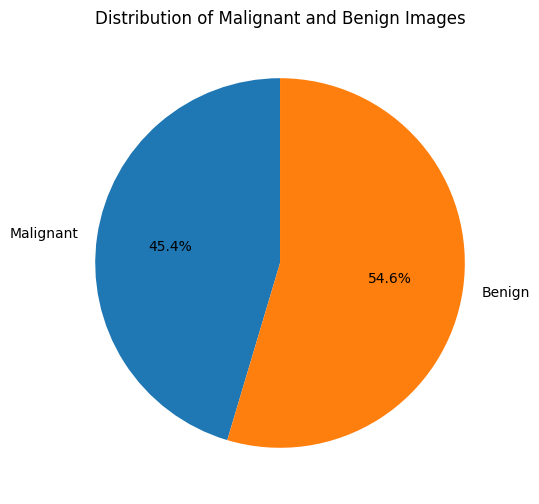

--------------------------------------------------------------------------------------------------------


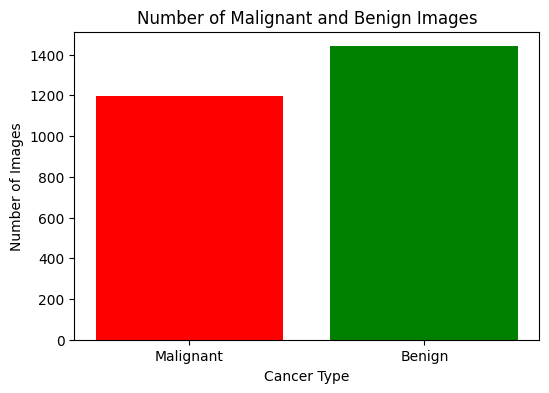

--------------------------------------------------------------------------------------------------------


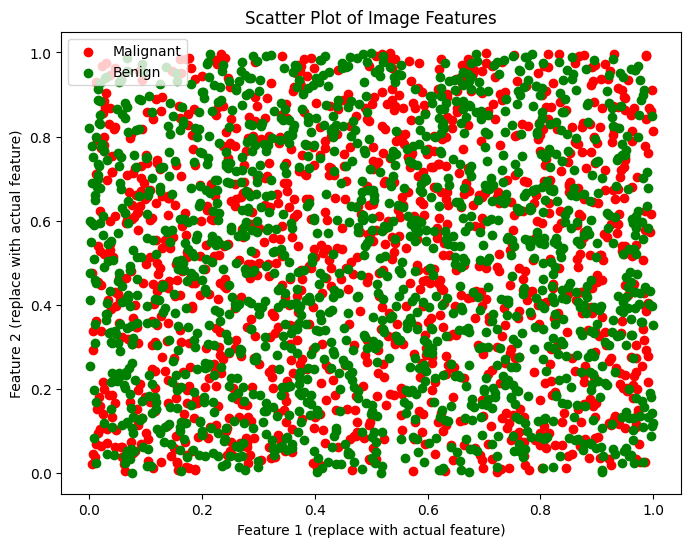

--------------------------------------------------------------------------------------------------------


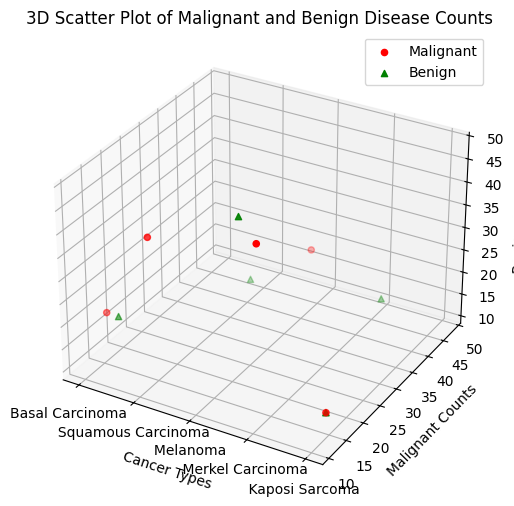

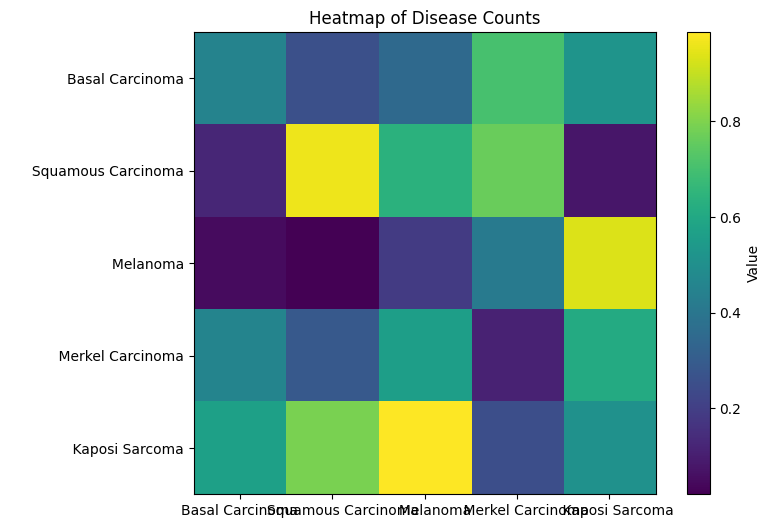

--------------------------------------------------------------------------------------------------------


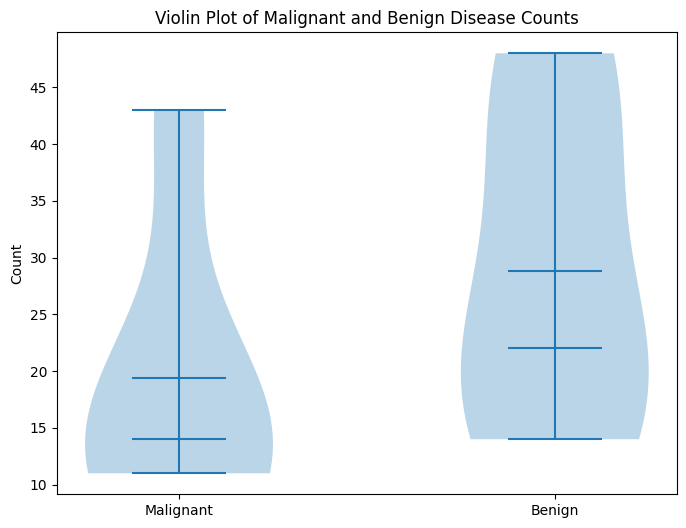

--------------------------------------------------------------------------------------------------------


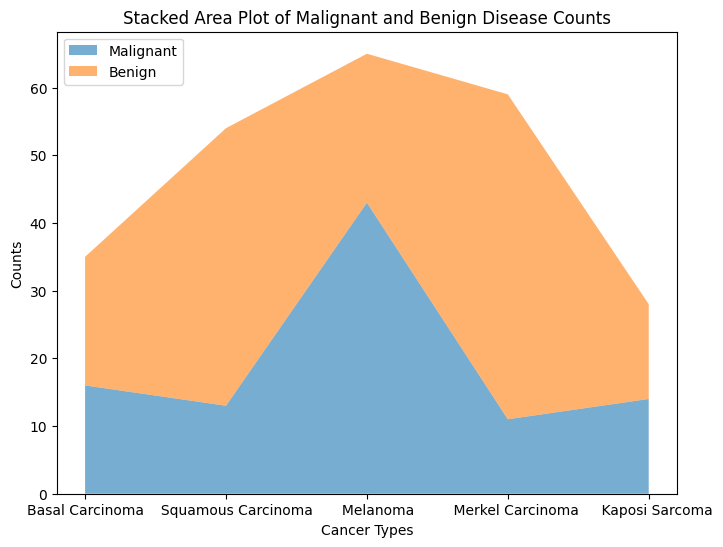

--------------------------------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from mpl_toolkits.mplot3d import Axes3D

# Links to the image directories
mal_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant/*')
ben_images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign/*')

# Sample data (replace with actual data from image features if available)
image_counts = pd.DataFrame({
    'Type': ['Malignant', 'Benign'],
    'Count': [len(mal_images), len(ben_images)]  # Image counts based on your dataset
})

# 1. Pie Chart: Distribution of Malignant and Benign Images
plt.figure(figsize=(6, 6))
plt.pie(image_counts['Count'], labels=image_counts['Type'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Malignant and Benign Images')
plt.show()
print("--------------------------------------------------------------------------------------------------------")

# 2. Bar Chart: Number of Malignant and Benign Images
plt.figure(figsize=(6, 4))
plt.bar(image_counts['Type'], image_counts['Count'], color=['red', 'green'])
plt.xlabel('Cancer Type')
plt.ylabel('Number of Images')
plt.title('Number of Malignant and Benign Images')
plt.show()
print("--------------------------------------------------------------------------------------------------------")


# 3. Scatter Plot: Random feature-based scatter (use actual image features when available)
# Example using synthetic data as placeholders for actual image features
np.random.seed(42)
malignant_x = np.random.rand(len(mal_images))
malignant_y = np.random.rand(len(mal_images))
benign_x = np.random.rand(len(ben_images))
benign_y = np.random.rand(len(ben_images))

plt.figure(figsize=(8, 6))
plt.scatter(malignant_x, malignant_y, color="red", label="Malignant")
plt.scatter(benign_x, benign_y, color="green", label="Benign")
plt.xlabel("Feature 1 (replace with actual feature)")
plt.ylabel("Feature 2 (replace with actual feature)")
plt.title("Scatter Plot of Image Features")
plt.legend()
plt.show()

print("--------------------------------------------------------------------------------------------------------")

# 4. 3D Scatter Plot for Malignant and Benign Counts
categories = ['Basal Carcinoma', '     Squamous Carcinoma', '     Melanoma',
              '    Merkel Carcinoma', '    Kaposi Sarcoma']

# Random example data for malignant and benign counts
malignant_counts = np.random.randint(10, 50, size=5)
benign_counts = np.random.randint(10, 50, size=5)

# Convert categories to numerical indices for plotting
numerical_categories = np.arange(len(categories))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for malignant counts
ax.scatter(numerical_categories, malignant_counts, benign_counts, c='r', marker='o', label='Malignant')

# Scatter plot for benign counts
ax.scatter(numerical_categories, benign_counts, malignant_counts, c='g', marker='^', label='Benign')

# Set x-axis ticks to the original category labels
ax.set_xticks(numerical_categories)
ax.set_xticklabels(categories)

# Labeling the axes
ax.set_xlabel('Cancer Types')
ax.set_ylabel('Malignant Counts')
ax.set_zlabel('Benign Counts')

# Adding title and legend
ax.set_title('3D Scatter Plot of Malignant and Benign Disease Counts')
ax.legend()

# Show plot
plt.show()

# 5. Heatmap: Example with random data
heatmap_data = np.random.rand(5, 5)  # Replace with actual data (e.g., correlations or counts)
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.xticks(np.arange(5), categories)
plt.yticks(np.arange(5), categories)
plt.title('Heatmap of Disease Counts')
plt.show()
print("--------------------------------------------------------------------------------------------------------")

# 6. Violin Plot: Example of distribution for Malignant and Benign Counts
data = {'Malignant': malignant_counts, 'Benign': benign_counts}
df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
plt.violinplot(df.values, showmeans=True, showmedians=True)
plt.xticks([1, 2], ['Malignant', 'Benign'])
plt.title('Violin Plot of Malignant and Benign Disease Counts')
plt.ylabel('Count')
plt.show()
print("--------------------------------------------------------------------------------------------------------")

# 7. Stacked Area Plot for Malignant and Benign Counts
plt.figure(figsize=(8, 6))
plt.stackplot(categories, malignant_counts, benign_counts, labels=['Malignant', 'Benign'], alpha=0.6)
plt.title('Stacked Area Plot of Malignant and Benign Disease Counts')
plt.xlabel('Cancer Types')
plt.ylabel('Counts')
plt.legend(loc='upper left')
plt.show()
print("--------------------------------------------------------------------------------------------------------")
